
Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Attaching sp



An object of class Seurat 
21107 features across 6984 samples within 1 assay 
Active assay: RNA (21107 features, 0 variable features)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Computing 2000 integration features

Scaling features for provided objects

Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 3548 anchors


Integrating dataset 2 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Centering and scaling data matrix

PC_ 1 
Positive:  UBE2C, CENPF, TPX2, TOP2A, CKS2, AURKA, MKI67, CCNB1, PLK1, DLGAP5 
	   KPNA2, HMMR, SGO2, CENPA, UBE2S, DEPDC1, ASPM, CDK1, KIF23, NUSAP1 
	   HJURP, KIF2C, HMGB2, AURKB, BUB3, CDCA3, FAM83D, GTSE1, TACC3, CALM2 
Negative:  AC106864.1, MCM5, SLIRP, MCM6, AC009446.1, TMSB10, UNG, HSPE1, E2F1, GABPB1-AS1 
	   FTL, GINS2, MCM4, DTL, UGP2, DUT, CDT1, EIF4

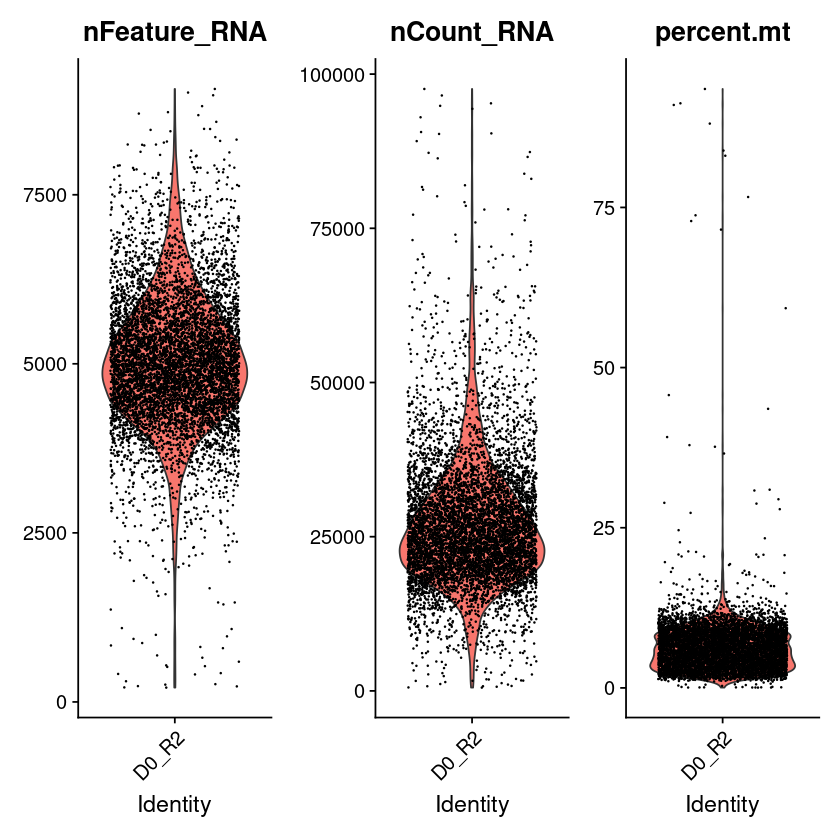

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
AAACCCAAGAGTTCGG-1_1,D0_R1,21919,4613,3.722798,1,1
AAACCCAAGGTCATTC-1_1,D0_R1,31778,6074,4.767449,4,4
AAACCCAAGTTAGTGA-1_1,D0_R1,25091,4821,11.163365,1,1
AAACCCACAAGATGTA-1_1,D0_R1,22547,4917,4.816605,4,4
AAACCCACAGAGTAAT-1_1,D0_R1,36628,6156,11.657748,3,3
AAACCCACAGCAGTCC-1_1,D0_R1,26341,5408,11.639649,2,2


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14535
Number of edges: 584212

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8648
Number of communities: 10
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
07:58:47 UMAP embedding parameters a = 0.9922 b = 1.112

07:58:47 Read 14535 rows and found 36 numeric columns

07:58:47 Using Annoy for neighbor search, n_neighbors = 30

07:58:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:58:49 Writing NN index file to temp file /tmp/RtmpC8GvcB/file64721c1f666

07:58:49 Searching Annoy index using 1 thread, search_k = 3000

07:58:54 Annoy recall = 100%

07:58:54 Commencing smooth kNN distance calibration using 1 thread

07:58:56 Initializing fro

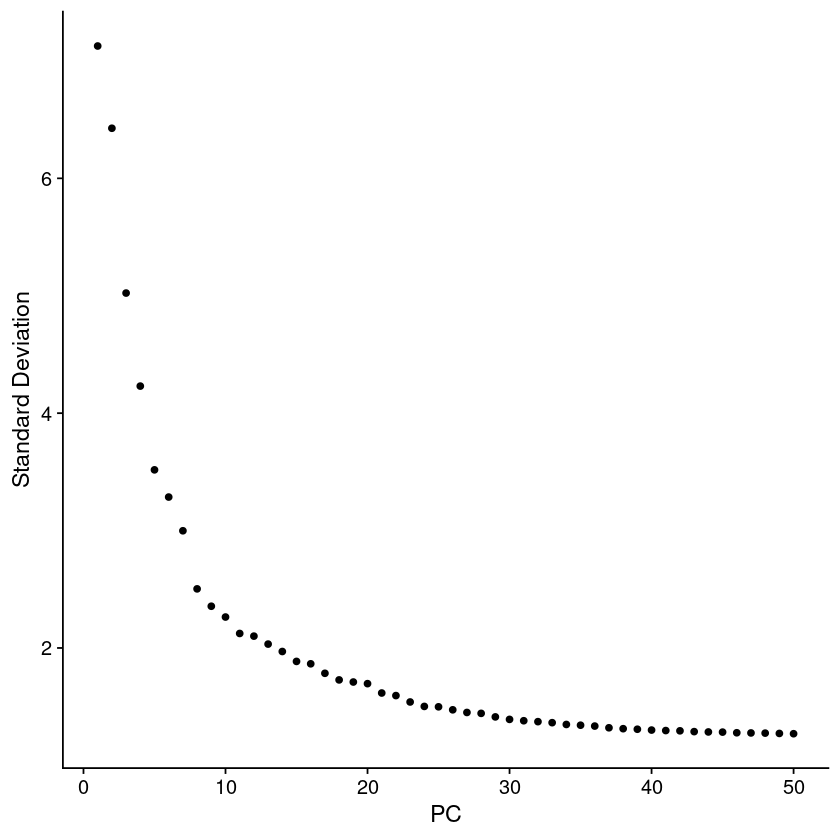

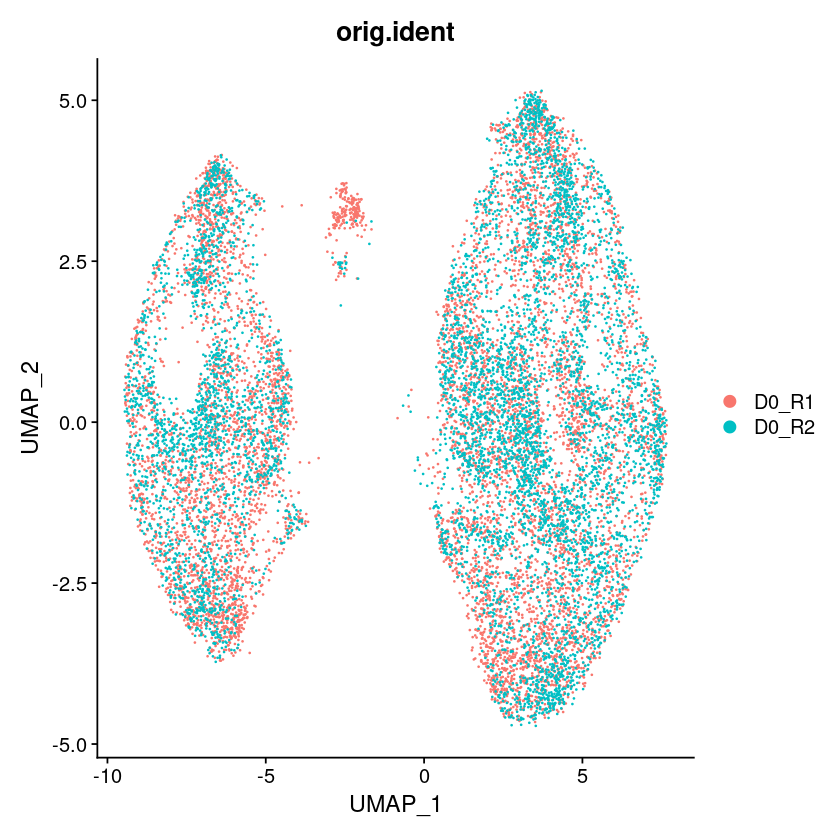

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)

# importing data 
D0_R2.data <- Read10X(data.dir = "/volume/DAY_0/D0_R2")
D0_R2 <- CreateSeuratObject(counts = D0_R2.data, project = "D0_R2", min.cells = 3, min.features = 200)
D0_R2

# Violin Plot
D0_R2[["percent.mt"]] <- PercentageFeatureSet(D0_R2, pattern = "^MT-")

VlnPlot(D0_R2, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# SUBSET DATA
D0_R2 <- subset(D0_R2, subset = nFeature_RNA > 2500 & nFeature_RNA < 8500 & percent.mt < 20)

# SAVE
saveRDS(D0_R2, file = "/volume/DAY_0/D0_R2/D0_R2_final.rds")

# List of Objects
D0_R1 <- readRDS("/volume/DAY_0/D0_R1/D0_R1_final.rds")
rna.list <- c(D0_R1, D0_R2)

# Normalize
rna.list <- lapply(X = rna.list, FUN = function(x) {
    x <- NormalizeData(x, verbose = FALSE)
    x <- FindVariableFeatures(x, verbose = FALSE)
})

# Scale and PCA 
features <- SelectIntegrationFeatures(object.list = rna.list)

rna.list <- lapply(X = rna.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})

# ANCHOR 
anchors <- FindIntegrationAnchors(object.list = rna.list, reference = c(1), reduction = "rpca", dims = 1:50)

# MERGE DATA
combined_obj <- IntegrateData(anchorset = anchors, dims = 1:50)

# ELBOWPLOT
all.genes <- rownames(combined_obj)
combined_obj <- ScaleData(combined_obj, features = all.genes)

combined_obj <- RunPCA(combined_obj, features = VariableFeatures(object = combined_obj))

ElbowPlot(combined_obj, ndims = 50)

# METADATA TABLE
head(combined_obj@meta.data)

# UMAP
combined_obj <- FindNeighbors(combined_obj, dims = 1:36)
combined_obj <- FindClusters(combined_obj, resolution = 0.5)

combined_obj <- RunUMAP(combined_obj, dims = 1:36)
DimPlot(combined_obj, group.by='orig.ident')